# Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", -1)
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from random import sample
import tensorflow as tf

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"maksahu","key":"cff8c0f086aa6e0e50553f7ab0580687"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data

In [ ]:
!kaggle competitions download -c data-science-bowl-2018

  0% 0.00/2.62k [00:00<?, ?B/s]
100% 2.62k/2.62k [00:00<00:00, 4.92MB/s]
 55% 5.00M/9.10M [00:00<00:00, 19.5MB/s]
100% 9.10M/9.10M [00:00<00:00, 30.3MB/s]
  0% 0.00/112k [00:00<?, ?B/s]
100% 112k/112k [00:00<00:00, 104MB/s]
  0% 0.00/2.67M [00:00<?, ?B/s]
100% 2.67M/2.67M [00:00<00:00, 88.7MB/s]
  0% 0.00/386k [00:00<?, ?B/s]
100% 386k/386k [00:00<00:00, 193MB/s]
 81% 64.0M/79.1M [00:00<00:00, 66.8MB/s]
100% 79.1M/79.1M [00:00<00:00, 147MB/s] 
 99% 274M/276M [00:03<00:00, 122MB/s]
100% 276M/276M [00:03<00:00, 87.0MB/s]


In [ ]:
#Creating these two folder
!mkdir train tes

In [ ]:
#Unziping the training and testing folders into directories
print('Unzipping stage1_train.zip')
!unzip -q "/content/stage1_train.zip" -d train/
print('Unzipped stage1_train.zip')

print('Unzipping stage1_test.zip')
!unzip -q "/content/stage1_train.zip" -d test/
print('Unzipped stage1_test.zip')

Unzipping stage1_train.zip
Unzipped stage1_train.zip
Unzipping stage1_test.zip
Unzipped stage1_test.zip


In [ ]:
# Root directories for training and testing
TRAIN_ROOT = './train'
TEST_ROOT = './test'

In [ ]:
# Function to create a dataframe of files which will be used for further processing
def files_df(root_dir):
    subdir = os.listdir(root_dir)
    files = []
    df = pd.DataFrame()
    for dir in subdir:
        files.append(os.path.join(root_dir,dir))
    df['files'] = files
    return df

In [ ]:
train_df = files_df(TRAIN_ROOT)
test_df = files_df(TEST_ROOT)

In [ ]:
# Hyperparameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
CLASSES = 1
BATCH_SIZE = 8

In [ ]:
# Function which will create a dataframe of image paths and mask paths along with creating a single mask from multiple masks
def image_df(filenames):
    image_paths = []
    mask_paths = []
    df = pd.DataFrame()
    for filename in tqdm(filenames):
        file_path = os.path.join(filename,'images')
        image_path = os.path.join(file_path,os.listdir(file_path)[0])
        image_paths.append(image_path)
        
        mask = np.zeros((IMG_WIDTH,IMG_HEIGHT,CLASSES))
        mask_dir = file_path.replace("images", "masks")
        masks = os.listdir(mask_dir)
        for m in masks:
            mask_path = os.path.join(mask_dir,m)
            mask_  = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            mask_  = cv2.resize(mask_,(IMG_WIDTH,IMG_HEIGHT),interpolation=cv2.INTER_NEAREST)
            mask_  = np.expand_dims(mask_, axis = -1)
            mask = np.maximum(mask,mask_)
        newmask_dir = mask_dir.replace("masks", "masks_")
        if not os.path.isdir(newmask_dir):
            os.mkdir(newmask_dir)
        newmask_path = image_path.replace("images", "masks_")
        mask_paths.append(newmask_path)
        cv2.imwrite(newmask_path, mask)
    df['images'] = image_paths
    df['masks'] = mask_paths
    return df

In [ ]:
train_filenames = train_df['files']
train = image_df(train_filenames)

100%|██████████| 670/670 [00:30<00:00, 22.32it/s]


# First Function

In [ ]:
def final_func_1(image_path):
  """
  This functions takes an image path as input and returns segmented image as output
  Input : Input Image
  Output : Segmented Image
  """ 
  # Reading and processing Image
  image_string = tf.io.read_file(image_path)
  image = tf.image.decode_png(image_string, channels=IMG_CHANNELS)#
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
  # Importing hrnet model
  model = tf.keras.models.load_model("/content/drive/MyDrive/CaseStudy2/hrnet_model.h5")
  # Predicting Semgentaions on Image using pretrained model
  pred_mask  = model.predict(image[np.newaxis,:,:,:])
  # Predicting Segmentations on Image using quantized model
  interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/CaseStudy2/quant_hrnet_model.tflite")
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], image[np.newaxis,:,:,:])
  interpreter.invoke()
  pred_mask_qh = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])
  # Displaying Image and Segmented Mask  
  fig = plt.figure(figsize=(10,6))
  
  ax1 = fig.add_subplot(131)
  ax1.title.set_text('Original Image')    
  ax1.imshow(image)

  ax2 = fig.add_subplot(132)
  ax2.title.set_text('HRNet')    
  ax2.imshow(pred_mask[0,:,:,0], cmap='gray')

  ax2 = fig.add_subplot(133)
  ax2.title.set_text('Quantized HRNet')    
  ax2.imshow(pred_mask_qh[0,:,:,0], cmap='gray')
  plt.show()

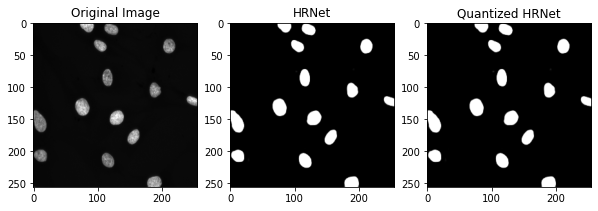

In [ ]:
# Sample Run
test_filenames = test_df['files']
filename = test_filenames.iloc[np.random.randint(len(test_filenames))]
file_path = os.path.join(filename,'images')
image_path = os.path.join(file_path,os.listdir(file_path)[0])
final_func_1(image_path)

# Second Function

In [ ]:
# Custom MeanIoU Metric function
class MeanIoU(tf.keras.metrics.Metric):
    def __init__(self, num_classes, thres=0.5, name='mean_iou', dtype=None):
        super(MeanIoU, self).__init__(name=name, dtype=dtype)
        self.num_classes = num_classes
        self.thres = thres
        self.total_cm = self.add_weight('total_confusion_matrix',
                                        shape=(num_classes, num_classes),
                                        initializer=tf.zeros_initializer())

    def update_state(self, y_true, y_pred, sample_weight=None):
        
        y_true = tf.cast(y_true, self._dtype)
        y_pred = tf.cast(y_pred, self._dtype)
        if y_pred.shape.ndims > 1:
            y_pred = tf.reshape(y_pred, [-1])
        if y_true.shape.ndims > 1:
            y_true = tf.reshape(y_true, [-1])
        
        y_pred = tf.where(y_pred > self.thres, 1.0, 0.0)
        
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, self._dtype)
            if sample_weight.shape.ndims > 1:
                sample_weight = tf.reshape(sample_weight, [-1])
        current_cm = tf.math.confusion_matrix(y_true,
                                              y_pred,
                                              self.num_classes,
                                              weights=sample_weight,
                                              dtype=self._dtype)
        
        return self.total_cm.assign_add(current_cm)

    def result(self):
        sum_over_row = tf.cast(tf.reduce_sum(self.total_cm, axis=0), dtype=self._dtype)
        sum_over_col = tf.cast(tf.reduce_sum(self.total_cm, axis=1), dtype=self._dtype)
        true_positives = tf.cast(tf.linalg.tensor_diag_part(self.total_cm), dtype=self._dtype)
        denominator = sum_over_row + sum_over_col - true_positives
        num_valid_entries = tf.reduce_sum(tf.cast(tf.math.not_equal(denominator, 0), dtype=self._dtype))
        iou = tf.math.divide_no_nan(true_positives, denominator)
        return tf.math.divide_no_nan(tf.reduce_sum(iou, name='mean_iou'), num_valid_entries)
    
    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        tf.keras.backend.set_value(self.total_cm, np.zeros((self.num_classes, self.num_classes)))
        
    def get_config(self):
        config = {'num_classes': self.num_classes}
        base_config = super(MeanIoU, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
def final_func_2(image_path,mask_path):
  """
  This functions takes an image path as input and returns segmented image as output
  Input : Input Image
  Output : Segmented Image
  """
  # performance metric
  m = MeanIoU(2, 0.4)
  # Reading and processing Image
  image_string = tf.io.read_file(image_path)
  image = tf.image.decode_png(image_string, channels=IMG_CHANNELS)#
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH]) # height x width
  # Reading and processing Mask
  mask_string = tf.io.read_file(mask_path)
  mask = tf.image.decode_png(mask_string, channels=CLASSES)#
  mask = tf.image.convert_image_dtype(mask, tf.float32)
  mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH])
  # Importing model
  model = tf.keras.models.load_model("/content/drive/MyDrive/CaseStudy2/hrnet_model.h5")
  # Predicting Semgentaions on Image using pretrained model
  pred_mask = model.predict(image[np.newaxis,:,:,:])
  # Predicting Segmentations on Image using quantized model
  interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/CaseStudy2/quant_hrnet_model.tflite")
  interpreter.allocate_tensors()
  interpreter.set_tensor(interpreter.get_input_details()[0]['index'], image[np.newaxis,:,:,:])
  interpreter.invoke()
  pred_mask_qh = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])
  # Finding and storing performance metric for HRNet
  m.update_state(mask, pred_mask)
  h_iou_score = m.result().numpy()
  # Finding and storing performance metric for quantized HRNet
  m.update_state(mask, pred_mask_qh)
  qh_iou_score = m.result().numpy()
  # Displaying Image, Mask and Segmented Mask
  fig = plt.figure(figsize=(12,8))
  
  ax1 = fig.add_subplot(141)
  ax1.title.set_text('Original Image')    
  ax1.imshow(image)
  
  ax2 = fig.add_subplot(142)
  ax2.title.set_text('Ground Truth')    
  ax2.imshow(mask[:,:,0], cmap='gray')
  
  ax3 = fig.add_subplot(143)
  ax3.title.set_text('HRNet'+'\n'+'IoU Score: '+str(h_iou_score))
  ax3.imshow(pred_mask[0,:,:,0], cmap='gray')

  ax3 = fig.add_subplot(144)
  ax3.title.set_text('Quantized HRNet'+'\n'+'IoU Score: '+str(qh_iou_score))
  ax3.imshow(pred_mask_qh[0,:,:,0], cmap='gray')
  plt.show()

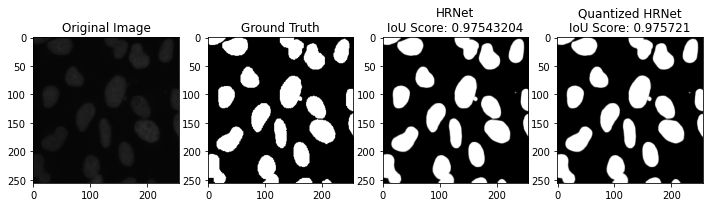

In [ ]:
# Sample Run
row1 = train.iloc[np.random.randint(len(train))]
image_path = row1['images']
mask_path = row1['masks']
final_func_2(image_path,mask_path)